# Bidirectional Encoder Representations from Transformers (BERT)

This notebook show a basic implementation of BERT pre-training using the wikipedia dataset.

In [1]:
# black formatting with jupyter-black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=140,
)

In [2]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# import libaries
import torch
import re

import numpy as np
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from torch import nn
import multiprocessing as mp

from typing import List
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import re

from tempfile import NamedTemporaryFile

from datasets import load_dataset


from utils import text_preprocessing

In [4]:
# download wikipedia dataset
data = load_dataset("wikipedia", "20220301.en", split="train[0:500]", trust_remote_code=True).to_pandas()

In [5]:
# split each text by "."
texts = []

for t_id, t in enumerate(data.text.tolist()):
    t = t.split(".")
    for sentence_id, sentence in enumerate(t):
        texts.append({"paragraph_id": t_id, "sentence_id": sentence_id, "text": sentence})

data = pd.DataFrame(texts)

# Tokenizer

We have implemented a Byte-Per Encoding Tokenizer. However, this python implementation is really slow and so we will use a transformers implementation of Word Piece Tokenizer 

In [6]:
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import BertPreTokenizer

In [7]:
# Initialize a tokenizer
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

# Set the pre-tokenizer to a custom one
tokenizer.pre_tokenizer = BertPreTokenizer()

# Enable padding for the tokenizer
# tokenizer.enable_padding()

# Initialize a trainer with desired parameters
trainer = trainers.WordPieceTrainer(vocab_size=30000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

# preprocess data
data.text = data.text.apply(text_preprocessing)

# Load your training data into a list of strings
train_data = data.text.tolist()

# Train the tokenizer
tokenizer.train_from_iterator(
    train_data,
    trainer=trainer,
)

In [8]:
tokenizer.encode("praying, she's a good person").tokens

['praying', ',', 'she', "'", 's', 'a', 'good', 'person']

In [9]:
# count number of words
data["text_length"] = data.text.apply(lambda x: len(tokenizer.encode(x).tokens))
data = data.query("text_length>=5 and text_length<=60").reset_index(drop=True)

<Axes: xlabel='text_length', ylabel='Count'>

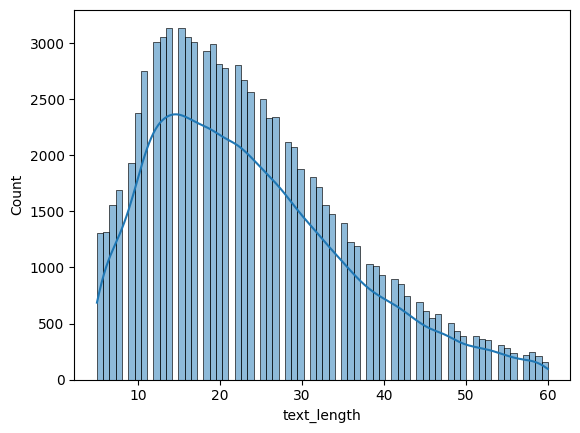

In [10]:
# plot number of words distribution
sns.histplot(data=data, x="text_length", kde=True)

## Create a dataset with  positive and negative samples for the Next Sentence Prediction (NSP) task

Now we create the dataset that will be sued for Next Sentence Prediction. In NSP, the model is given two sentences and must predict whether the second sentence logically follows the first sentence in a coherent narrative or if the two sentences are unrelated. This task helps the model understand the relationships between sentences and improve its comprehension of text flow, context, and continuity.

In [11]:
def get_nsp_sample(dataset, idx):
    """
    Generates a sample for the Next Sentence Prediction (NSP) task.

    Arguments:
    ----------
        dataset (pd.DataFrame): The dataset containing text, paragraph_id, and sentence_id columns.
        idx (int): The index of the sentence to be used as the first sentence (sentence_a).

    Returns:
    --------
        tuple: A tuple containing:
            - sentence_a (str): The first sentence.
            - sentence_b (str): The second sentence, which can either be a coherent follow-up sentence or an unrelated one.
            - nsp_label (int): The label indicating if sentence_b is a follow-up (1) or not (0).
    """
    sentence_a = dataset.loc[idx, "text"]
    paragraph_id_a = dataset.loc[idx, "paragraph_id"]
    sentence_id_a = dataset.loc[idx, "sentence_id"]

    prob_nsp = np.random.random()

    if prob_nsp >= 0.5:
        sentence_b, nsp_label = get_positive_pair(dataset, paragraph_id_a, sentence_id_a)
    else:
        sentence_b, nsp_label = get_negative_pair(dataset, paragraph_id_a, sentence_id_a, hard_negative=False)

    if sentence_b is None:
        sentence_b, nsp_label = get_negative_pair(dataset, paragraph_id_a, sentence_id_a, hard_negative=False)

    return sentence_a, sentence_b, nsp_label


def get_positive_pair(dataset, paragraph_id_a, sentence_id_a):
    """
    Retrieves a positive sentence pair for the NSP task, where the second sentence follows the first.

    Arguments:
    ----------
        dataset (pd.DataFrame): The dataset containing text, paragraph_id, and sentence_id columns.
        paragraph_id_a (int): The paragraph ID of the first sentence.
        sentence_id_a (int): The sentence ID of the first sentence.

    Returns:
    --------
        tuple: A tuple containing:
            - sentence_b (str or None): The next sentence if it exists, otherwise None.
            - nsp_label (int): The label indicating this is a follow-up sentence (1).
    """
    nsp_label = 1
    sentence_id_b = sentence_id_a + 1

    try:
        sentence_b = dataset.query(f"paragraph_id == {paragraph_id_a} and sentence_id == {sentence_id_b}").text.iloc[0]
    except:
        sentence_b = None

    return sentence_b, nsp_label


def get_negative_pair(dataset, paragraph_id_a, sentence_id_a, hard_negative=False):
    """
    Retrieves a negative sentence pair for the NSP task, where the second sentence does not follow the first.

    Arguments:
    ----------
        dataset (pd.DataFrame): The dataset containing text, paragraph_id, and sentence_id columns.
        paragraph_id_a (int): The paragraph ID of the first sentence.
        sentence_id_a (int): The sentence ID of the first sentence.
        hard_negative (bool): If True, the second sentence is chosen from the same paragraph but is not the next sentence. 
                              If False, the second sentence is chosen from a different paragraph.

    Returns:
    --------
        tuple: A tuple containing:
            - sentence_b (str): The unrelated sentence.
            - nsp_label (int): The label indicating this is not a follow-up sentence (0).
    """
    nsp_label = 0

    if hard_negative:
        sentence_b = dataset.query(f"paragraph_id == {paragraph_id_a} and sentence_id != {sentence_id_a}").sample(1).text.iloc[0]
    else:
        sentence_b = dataset.query(f"paragraph_id != {paragraph_id_a}").sample(1).text.iloc[0]

    return sentence_b, nsp_label


In [12]:
# prepare dataset for NSP
sentence_a = []
sentence_b = []
label = []

for i in range(len(data)):

    a, b, l = get_nsp_sample(data, i)

    sentence_a.append(a)
    sentence_b.append(b)
    label.append(l)

data["sentence_a"] = sentence_a
data["sentence_b"] = sentence_b
data["label"] = label

In [15]:
data.label.value_counts()

label
0    47584
1    38916
Name: count, dtype: int64

# Custom Dataset And Data Collator

We define a custom data that prepare data MLM and NSP pre-trainig

In [16]:
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import torch

In [17]:
class CustomDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame, hard_negative=False) -> None:
        super().__init__()

        self.dataset = dataset
        self.hard_negative = hard_negative
        self.sep_token_id = tokenizer.encode("[SEP]").ids
        self.cls_token_id = tokenizer.encode("[CLS]").ids

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx):

        sentence_a = self.dataset.sentence_a.tolist()[idx]
        sentence_b = self.dataset.sentence_b.tolist()[idx]
        nsp_label = self.dataset.label.tolist()[idx]

        # sentence_a, sentence_b, nsp_label = self.get_nsp_sample(idx)

        sentence = f"[CLS] {sentence_a} [SEP] {sentence_b}"
        ids, mlm_labels = self.get_masked_sentence(sentence)

        return ids, mlm_labels, nsp_label

    def get_masked_sentence(self, sentence):

        encoded_sentence = tokenizer.encode(sentence, add_special_tokens=False)
        ids = np.array(encoded_sentence.ids)

        n_mask_tokens = max(1, round(len(ids) * 0.15))

        sep_index = (ids == tokenizer.token_to_id("[SEP]")).argmax()
        candidate_mask = np.arange(len(ids))
        candidate_mask = candidate_mask[~np.isin(candidate_mask, [0, sep_index])]

        selected_tokens = np.random.choice(candidate_mask, size=n_mask_tokens, replace=False)
        # selected_tokens_ids = ids[selected_tokens]
        mlm_labels = ids.copy()
        ids[selected_tokens] = tokenizer.token_to_id("[MASK]")

        return ids.tolist(), mlm_labels.tolist()

In [18]:
class DataCollatorForMLMAndNSP:

    def __init__(self, pad_token_id=0) -> None:

        self.pad_token_id = pad_token_id

    def __call__(self, sentences):

        ids = [torch.LongTensor(tokens[0]) for tokens in sentences]
        mlm_labels = [torch.LongTensor(tokens[1]) for tokens in sentences]
        # pos_masked_ids = [torch.LongTensor(tokens[2]) for tokens in sentences]
        nsp_labels = torch.LongTensor([[tokens[2]] for tokens in sentences]).squeeze(1)

        token_ids = pad_sequence(ids, padding_value=self.pad_token_id, batch_first=True)
        mlm_labels = pad_sequence(mlm_labels, padding_value=self.pad_token_id, batch_first=True)
        attention_masks = torch.ne(token_ids, self.pad_token_id).long()
        attention_masks = attention_masks.unsqueeze(1).unsqueeze(2)

        return token_ids, attention_masks, mlm_labels, nsp_labels

In [19]:
ds = CustomDataset(data, False)
data_loader = DataLoader(ds, batch_size=2, collate_fn=DataCollatorForMLMAndNSP(pad_token_id=0))

In [20]:
tokens, attention_mask, mlm_labels, nsp_labels = next(iter(data_loader))

In [21]:
tokens

tensor([[    2,  5558,     4,     4,  2427,  2976,  1179,  3290,  1238,  1203,
         20430,     4,  1172,     4,  1179,     4,  1364, 28030,    16,     4,
          2895,  1172, 12797,     3,  5558,  6926,  1208,  1161,  9201,  1172,
          1161,  1681,    16,  1304,  1241,  6205,  1185,  1214, 18260,    16,
         20872, 14185,    16,  1179,     4,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [    2,  5558,  6926,  1208,     4,  9201,  1172,  1161,  1681,    16,
          1304,  1241,  6205,  1185,  1214, 18260,    16,     4, 14185,    16,
          1179, 15714,     3,  1198,    32,  6376,     4,    17,  6319,  3290,
            16,  4375,  1219,  1161,     4,  3002,     4,  1172,  1161,  2427,
          7733,    16,  1241,  1203,  2666,  2749,     4, 14872,  1416, 

In [22]:
attention_mask

tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1]]]])

In [23]:
mlm_labels

tensor([[    2,  5558,  1203,    32,  2427,  2976,  1179,  3290,  1238,  1203,
         20430,  1281,  1172,  4413,  1179, 19344,  1364, 28030,    16, 18848,
          2895,  1172, 12797,     3,  5558,  6926,  1208,  1161,  9201,  1172,
          1161,  1681,    16,  1304,  1241,  6205,  1185,  1214, 18260,    16,
         20872, 14185,    16,  1179, 15714,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [    2,  5558,  6926,  1208,  1161,  9201,  1172,  1161,  1681,    16,
          1304,  1241,  6205,  1185,  1214, 18260,    16, 20872, 14185,    16,
          1179, 15714,     3,  1198,    32,  6376,  2559,    17,  6319,  3290,
            16,  4375,  1219,  1161, 13837,  3002,  2559,  1172,  1161,  2427,
          7733,    16,  1241,  1203,  2666,  2749,  7513, 14872,  1416, 

In [24]:
nsp_labels

tensor([1, 1])

In [25]:
tokenizer.decode(tokens[0].tolist(), skip_special_tokens=False)

'[CLS] anarchism [MASK] [MASK] political philosophy and movement that is scept [MASK] of [MASK] and [MASK] all involuntary , [MASK] forms of hierarchy [SEP] anarchism calls for the abolition of the state , which it holds to be unnecessary , undes ##irable , and [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## BERT Model implementation

In [26]:
from utils import EncoderTransformer
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import torch

In [27]:
class BERT(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, pf_dim, vocab_size, max_length, n_layers, device) -> None:
        super().__init__()

        self.encoder = EncoderTransformer(embed_dim, num_heads, dropout, pf_dim, vocab_size, max_length, n_layers, device=device)
        self.nsp_dnn = torch.nn.Linear(embed_dim, 2, device=device)
        self.mlm_dnn = torch.nn.Linear(embed_dim, vocab_size, device=device)

        self.device = device

    def config_training_args(self, optimizer, optimizer_kwargs={}):

        self.optimizer = optimizer(self.parameters(), **optimizer_kwargs)

    def forward(self, x, mask):

        import torch

        torch.cuda.synchronize()

        x = self.encoder(x, mask)

        y_mlm = self.mlm_dnn(x)
        y_nsp = self.nsp_dnn(x[:, 0, :])

        return y_mlm, y_nsp

    def train_one_epoch(self, train_loader):

        bar = tqdm(train_loader)
        running_total_loss = 0
        running_mlm_loss = 0
        running_nsp_loss = 0
        running_f1 = 0

        for step, (ids, attention_mask, mlm_labels, nsp_labels) in enumerate(bar, 1):

            # map to device
            ids = ids.to(self.device)
            attention_mask = attention_mask.to(self.device)
            mlm_labels = mlm_labels.to(self.device)
            nsp_labels = nsp_labels.to(self.device)

            y_mlm, y_nsp = self(ids, attention_mask)
            y_mlm = y_mlm.reshape(-1, y_mlm.shape[-1])
            mlm_labels = mlm_labels.reshape(-1)

            # compute mlm loss
            mlm_loss = torch.nn.functional.cross_entropy(y_mlm, mlm_labels, ignore_index=0)

            # compute nsp loss
            nsp_loss = torch.nn.functional.cross_entropy(y_nsp, nsp_labels)

            # total loss
            loss = nsp_loss + mlm_loss

            # clear grads
            self.optimizer.zero_grad()

            # backward
            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

            # optimization step
            self.optimizer.step()

            # running total losses
            running_mlm_loss += mlm_loss.item()
            running_nsp_loss += nsp_loss.item()
            running_total_loss += loss.item()

            # running f1 score
            y_nsp = torch.argmax(y_nsp, dim=-1)
            running_f1 += f1_score(nsp_labels.cpu(), y_nsp.cpu(), average="macro")

            bar.set_description(
                f"total loss: {running_total_loss / step:0.3f} | "
                + f"mlm loss: {running_mlm_loss / step:0.3f} | "
                + f"nsp loss: {running_nsp_loss / step:0.3f} | "
                + f"f1: {running_f1 / step:0.3f}"
            )

    def train(self, train_data, num_epochs):

        bar = tqdm(range(num_epochs))

        for epoch in bar:

            self.train_one_epoch(train_data)

            bar.set_description(f"epoch: {epoch}")

    def mask_filling(self, sentence: str, tokenizer):

        sentence = "[CLS]" + sentence + "[SEP]"
        token_ids = torch.LongTensor([tokenizer.encode(sentence).ids]).to(self.device)
        attention_mask = torch.ne(token_ids, tokenizer.encode("[PAD]").ids[0]).long().to(self.device)

        with torch.no_grad():

            y_mlm, _ = self(token_ids, attention_mask)

            y_mlm = y_mlm.argmax(dim=-1)

            sentence = tokenizer.decode(y_mlm[0].tolist())

            return sentence

    def nsp_prediction(self, sentence_a, sentence_b, tokenizer):

        sentence = "[CLS]" + sentence_a + "[SEP]" + sentence_b
        token_ids = torch.LongTensor([tokenizer.encode(sentence).ids]).to(self.device)
        attention_mask = torch.ne(token_ids, tokenizer.encode("[PAD]").ids[0]).long().to(self.device)

        with torch.no_grad():

            _, y_nsp = self(token_ids, attention_mask)

            y_nsp = torch.argmax(y_nsp, dim=-1)

        return y_nsp.item()

In [28]:
ds = CustomDataset(data, False)
data_loader = DataLoader(ds, batch_size=32, collate_fn=DataCollatorForMLMAndNSP(pad_token_id=0), num_workers=5, prefetch_factor=5)

In [29]:
# define model parameters
embed_dim = 512
max_length = 128
num_heads = 8
vocab_size = 30000
n_layers = 6
dropout = 0.3
pf_dim = 512

In [30]:
bert_model = BERT(embed_dim, num_heads, dropout, pf_dim, vocab_size, max_length, n_layers, device="cuda")

In [31]:
# config model
optimizer = torch.optim.Adam

bert_model.config_training_args(optimizer=optimizer, optimizer_kwargs={"lr": 2e-5})

In [32]:
bert_model.train(data_loader, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

In [91]:
bert_model.mask_filling(
    "[CLS] humans lived in societies without formal hierarchies long before the [MASK] of formal states, realms, or [MASK]",
    tokenizer,
)

'humans lived in societies without formal hierarch ##ies long before the , of formal states , realms , or the'

In [88]:
bert_model.nsp_prediction(
    sentence_a="humans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires",
    sentence_b="domesticated almonds appear in the early bronze age (bc), such as the archaeological sites of numeira (jordan), or possibly earlier",
    tokenizer=tokenizer,
)

0